In [1]:
using HePPCAT, LinearAlgebra, Plots, Random, Statistics, StatsPlots, Printf
using Plots.PlotMeasures
include("petrels.jl")
include("grouse.jl")
include("shasta.jl")

┌ Info: Precompiling HePPCAT [5b0c0c40-6f85-415d-b828-3ce01d5b51ec]
└ @ Base loading.jl:1317
┌ Warning: Package HePPCAT does not have Statistics in its dependencies:
│ - If you have HePPCAT checked out for development and have
│   added Statistics as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HePPCAT
└ Loading Statistics into HePPCAT from project dependency, future warnings for HePPCAT are suppressed.


updatefmm! (generic function with 1 method)

In [2]:
function plottraces(stats,labels,colors,markers,interval,alpha,figsize,fontsize,title::String,xlabel::String,legend=:outerright,yaxis=:linear)
  
    p = plot(size=figsize,legend=legend,title=title,xlabel=xlabel,yaxis=yaxis,
        xtickfont=font(fontsize), 
        ytickfont=font(fontsize), 
        guidefont=font(fontsize), 
        legendfont=font(fontsize),
        titlefont=font(fontsize))
    for (stat,label) in zip(stats,labels)
        plot!(p,[trace for trace in stat],alpha=alpha,color=colors[label],label="")
        plot!(p,1:interval:length(mean(stat)),mean(stat)[1:interval:length(mean(stat))],color=colors[label],linestyle=:dash,markershape=markers[label],width=2,label=label)
    end
    
    
    return p
end

function plottraces(stats,times,labels,colors,alpha,figsize,fontsize,title::String,xlabel::String,legend=:outerright,yaxis=:linear)

    p = plot(size=figsize,legend=legend,title=title,xlabel=xlabel,yaxis=yaxis,
        xtickfont=font(fontsize), 
        ytickfont=font(fontsize), 
        guidefont=font(fontsize), 
        legendfont=font(fontsize),
        titlefont=font(fontsize))
    for (stat,time,label) in zip(stats,times,labels)
        medianTime = median(cumsum(hcat(time...),dims=1),dims=2)[:]
        medianTrace = median(hcat(stat...),dims=2)[:]
        plot!(p,[(cumsum(_time),trace[2:end]) for (_time,trace) in zip(time,stat)],alpha=alpha,color=colors[label],label="")
        plot!(p,(medianTime,medianTrace[2:end]),color=colors[label],linestyle=:dash,width=2,label=label)
    end
    
    
    return p
end

plottraces (generic function with 6 methods)

### Incremental over batch

In [3]:
# d, n, v, λ = 50, [200,800], [1,4], [4,2,1]
# d, n, v, λ = 50, [200,800], [0.1,1], [4,2,1]
# d, n, v, λ = 50, [200,800], [1e-4,1e-2], [4,2,1]

# d, n, v, λ = 50, [500,2000], [0.001,0.01], [4,2,1]
d, n, v, λ = 100, [500,2000], [1e-2,1e-1], [4,2,1]
# d, n, v, λ = 50, [500,2000], [1e-2,1e-2], [4,2,1]

# d, n, v, λ = 50, [100,1000], [1e-2,1], [4,2,1]
k, L = length(λ), length(v)
khat = 3;

num_trials = 10

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
missing = 0.0
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) + sqrt(v[l])*randn(d,n[l]) for l in 1:L]
Y = [Ω[l] .* Ytrue[l] for l in 1:L]

### HePPCAT (Batch)
heppcat_time_log = []
for _=1:20
    tHeppcat = @elapsed begin
        Mheppcat = heppcat(Y,k,100) 
    end
    push!(heppcat_time_log,tHeppcat)
end
tHeppcat = median(heppcat_time_log)
Mheppcat = heppcat(Y,k,100) 

### True model
Mtrue = HePPCATModel(U,λ,I(k),v)

### Homoscedastic PPCA
cor = sum(Y[l]*Y[l]' for l in 1:L)/sum(n)
λh, Uh = eigen(Hermitian(cor),sortby=-)
λb = mean(λh[khat+1:end])
Mppca = HePPCATModel(Uh[:,1:khat],λh[1:khat] .- λb,I(khat),fill(λb,L))

### PPCA-G1
cor = Y[1]*Y[1]'/sum(n[1])
λh, Uh = eigen(Hermitian(cor),sortby=-)
λb = mean(λh[khat+1:end])
Mppca1 = HePPCATModel(Uh[:,1:khat],λh[1:khat] .- λb,I(khat),fill(λb,L))

### PPCA-G2
cor = Y[2]*Y[2]'/sum(n[2])
λh, Uh = eigen(Hermitian(cor),sortby=-)
λb = mean(λh[khat+1:end])
Mppca2 = HePPCATModel(Uh[:,1:khat],λh[1:khat] .- λb,I(khat),fill(λb,L))


### Streaming-setup
Ymat_true = hcat([Ytrue[l] for l=1:L]...)
Ymat = hcat([Y[l] for l=1:L]...)
vmat = vcat([v[l]*ones(n[l]) for l=1:L]...)
groups = Int64.(vcat([l*ones(n[l]) for l=1:L]...));
ΩY = abs.(Ymat) .> 0

dataIdx = randperm(sum(n))
# dataIdx = 1:sum(n)
Ymat = Ymat[:,dataIdx]
Ymat_true = Ymat_true[:,dataIdx]
ΩY = ΩY[:,dataIdx]
groups = groups[dataIdx]

Ltrue = loglikelihood(Mtrue,Ytrue)
stats_fcn(M) = loglikelihood(M,Ytrue) - Ltrue

### Streaming over each group
dataIdx1 = randperm(n[1])
dataIdx2 = randperm(n[2])
Y1mat = Y[1][:,dataIdx1]
Y2mat = Y[2][:,dataIdx2]
ΩY1 = Ω[1][:,dataIdx1]
ΩY2 = Ω[2][:,dataIdx2];

In [4]:
function Fmeasure(M)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
#     return norm(Fhat*Fhat' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

Fmeasure (generic function with 1 method)

##### Run PETRELS (full data)

In [5]:
# M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),v)
# Mstream = deepcopy(M0)
λ = 1
# λ = sqrt(2*d*pi*maximum(v))
δ = 1e-1
petrels_stats_trials = []
petrels_err_trials = []
petrels_time_trials = []

### Compile for dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, Yrec, stats_log, err_log, time_log = PETRELS(Mstream,Ymat,ΩY,λ,δ)

Random.seed!(0)
for _=1:num_trials    
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, Yrec, stats_log, err_log, time_log = PETRELS(Mstream,Ymat,ΩY,λ,δ)
    push!(petrels_stats_trials,stats_log)
    push!(petrels_err_trials,err_log)
    push!(petrels_time_trials,time_log)
end

##### PETRELS (Group 1)

In [6]:
# M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),v)
# Mstream = deepcopy(M0)
λ = 1
# λ = sqrt(2*d*pi*maximum(v))
δ = 1e-1
petrels_stats_trials_g1 = []
petrels_err_trials_g1 = []
petrels_time_trials_g1 = []

### Compile for dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mstream = deepcopy(M0)
Mstream, Yrec, stats_log, err_log, time_log = PETRELS(Mstream,Y1mat,ΩY1,λ,δ)

Random.seed!(0)
for _=1:num_trials    
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, Yrec, stats_log, err_log, time_log = PETRELS(Mstream,Y1mat,ΩY1,λ,δ)
    push!(petrels_stats_trials_g1,stats_log)
    push!(petrels_err_trials_g1,err_log)
    push!(petrels_time_trials_g1,time_log)
end

##### PETRELS (Group 2)

In [7]:
# M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),v)
# Mstream = deepcopy(M0)
λ = 1
# λ = sqrt(2*d*pi*maximum(v))
δ = 1e-1
petrels_stats_trials_g2 = []
petrels_err_trials_g2 = []
petrels_time_trials_g2 = []

### Compile for dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mstream = deepcopy(M0)
Mstream, Yrec, stats_log, err_log, time_log = PETRELS(Mstream,Y2mat,ΩY2,λ,δ)
Random.seed!(0)
for _=1:num_trials    
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, Yrec, stats_log, err_log, time_log = PETRELS(Mstream,Y2mat,ΩY2,λ,δ)
    push!(petrels_stats_trials_g2,stats_log)
    push!(petrels_err_trials_g2,err_log)
    push!(petrels_time_trials_g2,time_log)
end

##### Run GROUSE

In [8]:
grouse_stats_trials = []
grouse_err_trials = []
grouse_time_trials = []

grouse_step = 0.01
# grouse_step = 0

### Compile for dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, stats_log, err_log, time_log = GROUSE(Mstream,Ymat,ΩY,grouse_step,stats_fcn,Fmeasure)
Random.seed!(0)
for _=1:num_trials    
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, stats_log, err_log, time_log = GROUSE(Mstream,Ymat,ΩY,grouse_step,stats_fcn,Fmeasure)
    push!(grouse_stats_trials,stats_log)
    push!(grouse_err_trials,err_log)
    push!(grouse_time_trials,time_log)
end

##### Run SHASTA-PCA

In [16]:
shasta_stats_trials = []
shasta_err_trials = []
shasta_time_trials = []
shasta_models = []

w = 1
wf = 1
# wv = 1
wv = 0.1

# w = 0.001
# wf = 1
# wv = 1

w1 = w
w2 = w

L = length(Y)
δ = 0.1
Yrec = deepcopy(Ymat)

### Compile the function on a dummy run
M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
Mstream = deepcopy(M0)
Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA(Mstream,Ymat,ΩY,groups,w1,w2,wf,wv,L,δ,Fmeasure,stats_fcn)

Random.seed!(0)
for _=1:num_trials
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA(Mstream,Ymat,ΩY,groups,w1,w2,wf,wv,L,δ,Fmeasure,stats_fcn)
    push!(shasta_stats_trials,stats_log)
    push!(shasta_err_trials,err_log)
    push!(shasta_time_trials,time_log)
    push!(shasta_models,Mstream)
end

##### Plot the results

In [17]:
stats = [petrels_stats_trials, grouse_stats_trials, shasta_stats_trials]
errs = [petrels_err_trials,petrels_err_trials_g1,petrels_err_trials_g2, grouse_err_trials, shasta_err_trials]
times = [petrels_time_trials,grouse_time_trials, shasta_time_trials]
labels = ["PETRELS","PETRELS-G1","PETRELS-G2","GROUSE","SHASTA-PCA"]
colors = Dict("PETRELS"=>:orange,"PETRELS-G1"=>:orange,"PETRELS-G2"=>:orange,"GROUSE"=>:purple,"SHASTA-PCA"=>:blue)
markers = Dict("PETRELS"=>:utriangle,"PETRELS-G1"=>:rect,"PETRELS-G2"=>:hexagon,"GROUSE"=>:circle,"SHASTA-PCA"=>:diamond)

# stats = [shasta_stats_trials]
# errs = [shasta_err_trials]
# times = [shasta_time_trials]
# labels = ["SHASTA-PCA"]
# colors = Dict("SHASTA-PCA"=>:blue)

missing_rate = Int(round((1-missing)*100))
interval = 250
alpha = 0.05
fontsize = 10
figsize = (400,300)

p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,"Subspace Error: $missing_rate % observed","Iteration",:outerright,:log)
hline!(p1,[Fmeasure(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
hline!(p1,[Fmeasure(Mppca)],linestyle=:dash,width=2,color=:black,label="PPCA")
hline!(p1,[Fmeasure(Mppca1)],linestyle=:dash,width=2,color=:green,label="PPCA-G1")
hline!(p1,[Fmeasure(Mppca2)],linestyle=:dash,width=2,color=:lightgreen,label="PPCA-G2")

figsize = (400,300)
colors = Dict("SHASTA-PCA"=>:blue)
p2 = plottraces([shasta_stats_trials],["SHASTA-PCA"],colors,markers,interval,alpha,figsize,fontsize,"Log-likelihood: $missing_rate % observed","Iteration",false,:linear)
hline!(p2,[stats_fcn(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
hline!(p2,[stats_fcn(Mppca)],linestyle=:dash,width=2,color=:black,label="PPCA")
# hline!(p2,[stats_fcn(Mppca1)],linestyle=:dash,width=2,color=:green,label="PPCA-G1")
# hline!(p2,[stats_fcn(Mppca2)],linestyle=:dash,width=2,color=:green,label="PPCA-G2")

ylims!(p2,(-1e5,1e4))
# ylims!(p2,(-1e5,1e4))
p = plot(p2,p1,layout = @layout([q1{0.38w} q2]),size=(700,300),bottom_margin=5mm)
# p = plot(p1,p2,layout = @layout([q1{0.5w} q2]),size=(800,300),bottom_margin=5mm)

file = "shasta_results/online_algs_iteration-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
# savefig(p,file)
plot(p)

┌ Warning: Skipped yaxis arg linear
└ @ Plots /Users/kgilman/.julia/packages/Plots/vsE7b/src/axes.jl:73


In [777]:
missing_rate = Int(round((1-missing)*100))
colors = Dict("PETRELS"=>:orange,"GROUSE"=>:purple,"SHASTA-PCA"=>:blue)
p1 = plottraces(errs,times,labels,colors,alpha,figsize,fontsize,"Subspace Error: $missing_rate % observed","Time (s)",:outerright,:log)
hline!(p1,[Fmeasure(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
hline!(p1,[Fmeasure(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

# p2 = plottraces(stats,times,labels,colors,alpha,figsize,fontsize,"Log-likelihood: $missing_rate % observed","Time (s)",:outerright,:linear)
# hline!(p2,[stats_fcn(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
# hline!(p2,[stats_fcn(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

scatter!(p1,(tHeppcat,Fmeasure(Mheppcat)),markershape=:diamond,color=:red,markersize=5,label="HePPCAT Time")
# scatter!(p2,(tHeppcat,stats_fcn(Mheppcat)),markershape=:diamond,color=:red,markersize=5,label="HePPCAT Time")

# xlims!(p1,(0,0.3))
# xlims!(p2,(0,0.3))
# ylims!(p2,(-3e5,1e4))
# ylims!(p2,(-1e5,1e4))
# p = plot(p1,p2,layout = @layout([q1{0.38w} q2]),size=(700,300),bottom_margin=5mm)
file = "shasta_results/online_algs_time-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
plot!(p1,size=(400,300))
# savefig(p1,file)
plot(p1)

LoadError: KeyError: key "PETRELS-G1" not found

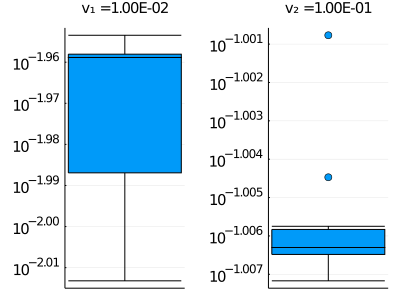

In [18]:
p1 = plot(size=(200,300),yaxis=:log,xtickfont=font(fontsize), 
        ytickfont=font(fontsize), 
        guidefont=font(fontsize), 
        legendfont=font(fontsize),
        titlefont=font(fontsize))
v1 = Mtrue.v[1]
v2 = Mtrue.v[2]
boxplot!(p1,[model.v[1] for model in shasta_models],label="",xticks=nothing,title= "v₁ =" * @sprintf("%.2E", v[1]))
# hline!([Mheppcat.v[1]],color=:red)
# yaxis!((Mtrue.v[1]*10^(-1),Mtrue.v[1]*10^(1)))

p2 = plot(size=(200,300),yaxis=:log,xtickfont=font(fontsize), 
        ytickfont=font(fontsize), 
        guidefont=font(fontsize), 
        legendfont=font(fontsize),
        titlefont=font(fontsize))
boxplot!(p2,[model.v[2] for model in shasta_models],label="",xticks=nothing,title= "v₂ ="* @sprintf("%.2E", v[2]))
# hline!([Mheppcat.v[2]],color=:red)
# yaxis!((Mtrue.v[2]*10^(-1),Mtrue.v[2]*10^(1)))

p = plot(p1,p2,layout=(1,2),size=(400,300))
file = "shasta_results/online_algs_variances-d_$d-n_$n-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
# savefig(p,file)
plot(p)

### Dynamic subspace

In [19]:
include("petrels.jl")

updatef! (generic function with 1 method)

In [20]:
d, v, λ = 100, [1e-4,1e-2], [4,2,1]
k, L = length(λ), length(v)
θ = 0.998
δ = 0.1

# w = 0.01
# wf = 0.01
# wv = 0.1

w = 0.01
wf = 0.01
wv = 0.1

w1 = w
w2 = w
grouse_step = 0.02
khat = 3

num_vectors = 10000
p = [1/5 4/5]

changeFIdx = 1:2500:num_vectors

M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))

## Init models
M_petrels = deepcopy(M0)
M_shasta = deepcopy(M0)
M_grouse = deepcopy(M0)

## Memory terms

petrelsRₜ⁺ = [δ*Matrix(I(k)) for i=1:d]

R = [δ*Matrix(I(k)) for i=1:d]
s = [zeros(k) for i=1:d]
ρ = zeros(L)
θshasta = zeros(L)

## Init stat logs
err_log_onlineHeppcat = []
err_log_petrels = []
err_log_shasta = []
err_log_grouse = []

U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))

function Fmeasure(M,F)
#     Fhat = M.U * Diagonal(M.λ).^(0.5) * M.Vt
#     return norm(Fhat*Fhat' - F*F') / norm(F*F')
    Uf = svd(F).U[:,1:k]
    Uhat = M.U
    
    return norm(Uhat*Uhat' - Uf*Uf') / norm(Uf*Uf')
end

missing = 0.5
err_fxn(M) = Fmeasure(M,F)
for t = 1:num_vectors
    
    ## Draw data vector
    if(t in changeFIdx)
        U = qr(rand(d,k)).Q[:,1:k]
        F = U*sqrt(Diagonal(λ))
        err_fxn(M) = Fmeasure(M,F)
    end
    l = rand() > (p[2]) ? 1 : 2
    Ωₜ = rand(d) .> missing
    yₜ  = Ωₜ .* (F*randn(k) + sqrt(v[l])*randn(d))

    ## Run the models
    streamPETRELS!(M_petrels,yₜ,Ωₜ,petrelsRₜ⁺,θ)
    streamSHASTA!(M_shasta,yₜ,Ωₜ,l,w1,w2,wf,wv,R,s,ρ,θshasta)
    streamGROUSE!(M_grouse, yₜ, Ωₜ, grouse_step)
    
    ## Collect stats
    push!(err_log_petrels, err_fxn(M_petrels))
    push!(err_log_shasta, err_fxn(M_shasta))
    push!(err_log_grouse, err_fxn(M_grouse))
    
end

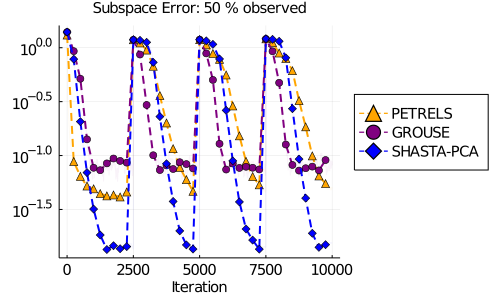

In [21]:
errs = [[err_log_petrels], [err_log_grouse], [err_log_shasta]]

labels = ["PETRELS","GROUSE","SHASTA-PCA"]
colors = Dict("PETRELS"=>:orange,"GROUSE"=>:purple,"SHASTA-PCA"=>:blue)
markers = Dict("PETRELS"=>:utriangle,"GROUSE"=>:circle,"SHASTA-PCA"=>:diamond)

missing_rate = Int(round((1-missing)*100))

interval = 250
p1 = plottraces(errs,labels,colors,markers,interval,alpha,figsize,fontsize,"Subspace Error: $missing_rate % observed","Iteration",:outerright,:log)
plot!(p1,size=(500,300))
file = "/Users/kgilman/Desktop/shasta/online_algs_dynamic-d_$d-n_$num_vectors-observedPercent_$missing_rate-v1_" * @sprintf("%.2E", v[1]) * "-v2_"* @sprintf("%.2E", v[2]) * ".png"
# savefig(p1,file)
plot!(p1)

In [765]:
M_shasta.v

2-element Vector{Float64}:
 0.00010121417050324756
 0.009963357730584281

#### Massive data experiment

In [ ]:
# d, n, v, λ = 50, [200,800], [1,4], [4,2,1]
# d, n, v, λ = 50, [200,800], [0.1,1], [4,2,1]
# d, n, v, λ = 50, [500,2000], [0.001,0.01], [4,2,1]
d, n, v, λ = 1000, [10000,50000], [1e-4,1e-2], [4,2,1]
k, L = length(λ), length(v)
khat = 3;

# Generate data
Random.seed!(0)
U = qr(rand(d,k)).Q[:,1:k]
F = U*sqrt(Diagonal(λ))
missing = 0.5
Ω = [(rand(d,n[l]) .> missing) for l in 1:L]
Ytrue = [F*randn(k,n[l]) + sqrt(v[l])*randn(d,n[l]) for l in 1:L]
Y = [Ω[l] .* Ytrue[l] for l in 1:L]

### HePPCAT (Batch)
heppcat_time_log = []
for _=1:20
    tHeppcat = @elapsed begin
        Mheppcat = heppcat(Y,k,100) 
    end
    push!(heppcat_time_log,tHeppcat)
end
tHeppcat = median(heppcat_time_log)
Mheppcat = heppcat(Y,k,100) 

### True model
Mtrue = HePPCATModel(U,λ,I(k),v)

### Homoscedastic PPCA
cor = sum(Y[l]*Y[l]' for l in 1:L)/sum(n)
λh, Uh = eigen(Hermitian(cor),sortby=-)
λb = mean(λh[khat+1:end])
Mppca = HePPCATModel(Uh[:,1:khat],λh[1:khat] .- λb,I(khat),fill(λb,L))

### Streaming-setup
Ymat_true = hcat([Ytrue[l] for l=1:L]...)
Ymat = hcat([Y[l] for l=1:L]...)
vmat = vcat([v[l]*ones(n[l]) for l=1:L]...)
groups = Int64.(vcat([l*ones(n[l]) for l=1:L]...));
ΩY = abs.(Ymat) .> 0

dataIdx = randperm(sum(n))
Ymat = Ymat[:,dataIdx]
Ymat_true = Ymat_true[:,dataIdx]
ΩY = ΩY[:,dataIdx]
groups = groups[dataIdx]

Ltrue = loglikelihood(Mtrue,Ytrue)
stats_fcn(M) = loglikelihood(M,Ytrue) - Ltrue

In [ ]:
shasta_stats_trials = []
shasta_err_trials = []
shasta_time_trials = []
shasta_models = []

w1 = 0.01
w2 = 0.1
L = 2
Yrec = deepcopy(Ymat)

# ### Compile the function on a dummy run
# M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
# Mstream = deepcopy(M0)
# Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA(Mstream,Ymat,ΩY,groups,w1,w2,L,δ,buffer=100)

for _=1:1
    M0 = HePPCATModel(Matrix(qr!(randn(d,khat)).Q),rand(khat),I(khat),rand(L))
    Mstream = deepcopy(M0)
    Mstream, Yrec, stats_log, err_log, time_log = SHASTA_PCA(Mstream,Ymat,ΩY,groups,w1,w2,L,δ,100)
    push!(shasta_stats_trials,stats_log)
    push!(shasta_err_trials,err_log)
    push!(shasta_time_trials,time_log)
    push!(shasta_models,Mstream)
end

In [ ]:
stats = [shasta_stats_trials]
errs = [ shasta_err_trials]
times = [shasta_time_trials]
labels = ["SHASTA-PCA"]
missing_rate = round((1-missing)*100)


In [ ]:
missing_rate = round((1-missing)*100)
p1 = plottraces(errs,times,labels,"Subspace Error: $missing_rate % observed","Time (s)",:log)
hline!(p1,[Fmeasure(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
hline!(p1,[Fmeasure(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

p2 = plottraces(stats,times,labels,"Log-likelihood: $missing_rate % observed","Time (s)",:linear)
hline!(p2,[stats_fcn(Mheppcat)],linestyle=:dash,width=2,color=:red,label="HePPCAT")
hline!(p2,[stats_fcn(Mppca)],linestyle=:dash,width=2,color=:green,label="PPCA")

scatter!(p1,(tHeppcat,Fmeasure(Mheppcat)),markershape=:diamond,color=:red,markersize=5,label="HePPCAT Time")
scatter!(p2,(tHeppcat,stats_fcn(Mheppcat)),markershape=:diamond,color=:red,markersize=5,label="HePPCAT Time")

# xlims!(p1,(0,0.5))
# xlims!(p2,(0,0.5))
plot(p1,p2,layout=(1,2),size=(800,300),bottom_margin=5mm)

In [ ]:
fxn(b,ai,aj) = 1/(b^2 + b*(ai + aj) + ai*aj)

b = 0:0.01:5
ai = 4
aj = 1
plot(b,fxn.(b,ai,aj))

ai = 3
aj = 2
plot!(b,fxn.(b,ai,aj))

ai = 1
aj = 1
plot!(b,fxn.(b,ai,aj))